## Homogeneous ice nucleation in an ab initio machine learning model of water
### Pablo M. Piaggi, Jack Weis, Athanassios Z. Panagiotopoulos, Pablo G. Debenedetti, and Roberto Car

In [1]:
import MDAnalysis
import freud
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.interpolate import interp1d, CubicSpline, LSQUnivariateSpline, UnivariateSpline, splev, splrep

In [2]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3*3.25, 3*2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Compute largest cluster size

In [3]:
def func_threshold(x,a,b):
    return a*x+b

popt_threshold=np.array([-0.00084,0.6334]) # This was calculated based on data of bulk simulations

def computeLargestClusterSize(filename,step,temperature):
    # Find threshold for this temperature (in K)
    threshold=func_threshold(temperature,*popt_threshold)
    print(threshold)
    ql = freud.order.Steinhardt(l=6,average=True)
    reader = MDAnalysis.coordinates.LAMMPS.DumpReader(filename)
    n_frames=sum(1 for e in reader[::step])
    n_solid_molecules=np.zeros(n_frames)
    n_solid_molecules_clust=np.zeros(n_frames)
    counter=0
    for frame in reader[::step]:
        ts = MDAnalysis.coordinates.base.Timestep(frame.positions[::3,:].shape[0])
        ts.positions=frame.positions[::3,:]
        ts.dimensions=frame.dimensions
        ql.compute(ts, {'r_max':3.5}) #,reset=False)
        n_solid_molecules[counter]=ql.ql[ql.ql>threshold].shape[0]
        if (ts.positions[ql.ql>threshold,:].shape[0]>0):
            ts2 = MDAnalysis.coordinates.base.Timestep(ts.positions[ql.ql>threshold,:].shape[0])
            ts2.positions=ts.positions[ql.ql>threshold,:]
            ts2.dimensions=ts.dimensions
            cl = freud.cluster.Cluster()
            cl_props = freud.cluster.ClusterProperties()
            cl.compute(ts2, neighbors={'r_max': 3.5})
            props = cl_props.compute(ts2, cl.cluster_idx)
            n_solid_molecules_clust[counter]=cl_props.sizes[0]
        else:
            n_solid_molecules_clust[counter]=0
        counter += 1
    return n_solid_molecules,n_solid_molecules_clust

## Cluster size ~200

In [5]:
step=100
n_solid_molecules200_255, n_solid_molecules200_255_clust = computeLargestClusterSize('cluster200molecules/255K/dump.water',step,255)
n_solid_molecules200_260, n_solid_molecules200_260_clust = computeLargestClusterSize('cluster200molecules/260K/dump.water',step,260)
n_solid_molecules200_265, n_solid_molecules200_265_clust = computeLargestClusterSize('cluster200molecules/265K/dump.water',step,265)
n_solid_molecules200_275, n_solid_molecules200_275_clust = computeLargestClusterSize('cluster200molecules/275K/dump.water',step,275)

0.41919999999999996
0.4149999999999999
0.41079999999999994
0.4024


In [6]:
np.save('n_solid_molecules200_255_clust.npy', n_solid_molecules200_255_clust)
np.save('n_solid_molecules200_260_clust.npy', n_solid_molecules200_260_clust)
np.save('n_solid_molecules200_265_clust.npy', n_solid_molecules200_265_clust)
np.save('n_solid_molecules200_275_clust.npy', n_solid_molecules200_275_clust)

In [7]:
# If already calculated, the results can be read using this cell
step=100
n_solid_molecules200_255_clust = np.load('n_solid_molecules200_255_clust.npy')
n_solid_molecules200_260_clust = np.load('n_solid_molecules200_260_clust.npy')
n_solid_molecules200_265_clust = np.load('n_solid_molecules200_265_clust.npy')
n_solid_molecules200_275_clust = np.load('n_solid_molecules200_275_clust.npy')

In [8]:
print(np.mean(n_solid_molecules200_255_clust[:20]))
print(np.mean(n_solid_molecules200_260_clust[:20]))

191.3
189.7


Thus, the initial mean cluster size is ~190 molecules

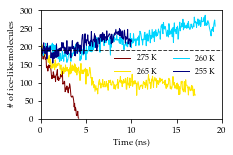

In [21]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3.25, 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(1,1)


colors2 = plt.cm.jet(np.linspace(0,1,4))
mylinewidth=1
step=100
timestep=0.0000005
step_dump=1000

n_frames=n_solid_molecules200_275_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules200_275_clust,label="275 K",linewidth=mylinewidth,color=colors2[3])
n_frames=n_solid_molecules200_265_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules200_265_clust,label="265 K",linewidth=mylinewidth,color=colors2[2])
n_frames=n_solid_molecules200_260_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules200_260_clust,label="260 K",linewidth=mylinewidth,color=colors2[1])
n_frames=n_solid_molecules200_255_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules200_255_clust,label="255 K",linewidth=mylinewidth,color=colors2[0])

plt.xlabel("Time (ns)")
plt.ylabel("\# of ice-like molecules")
plt.legend(frameon=False,fontsize=8,ncol=2)
plt.xlim([0,20])
plt.ylim([0,300])
plt.plot([0,20],[190,190],'--',alpha=0.75,linewidth=1,color='black')

#plt.savefig("plot_cluster200.png",dpi=300,bbox_inches='tight')  # publication quality
plt.show()

## Cluster size ~700

In [11]:
step=10
n_solid_molecules600_275, n_solid_molecules600_275_clust = computeLargestClusterSize('cluster600molecules/275-280K/dump.water.0',step,275)
n_solid_molecules600_276, n_solid_molecules600_276_clust = computeLargestClusterSize('cluster600molecules/275-280K/dump.water.1',step,276)
n_solid_molecules600_277, n_solid_molecules600_277_clust = computeLargestClusterSize('cluster600molecules/275-280K/dump.water.2',step,277)
n_solid_molecules600_278, n_solid_molecules600_278_clust = computeLargestClusterSize('cluster600molecules/275-280K/dump.water.3',step,278)
n_solid_molecules600_279, n_solid_molecules600_279_clust = computeLargestClusterSize('cluster600molecules/275-280K/dump.water.4',step,279)
n_solid_molecules600_280, n_solid_molecules600_280_clust = computeLargestClusterSize('cluster600molecules/275-280K/dump.water.5',step,280)
n_solid_molecules600_281, n_solid_molecules600_281_clust = computeLargestClusterSize('cluster600molecules/281-286K/dump.water.0',step,281)
n_solid_molecules600_282, n_solid_molecules600_282_clust = computeLargestClusterSize('cluster600molecules/281-286K/dump.water.1',step,282)
n_solid_molecules600_283, n_solid_molecules600_283_clust = computeLargestClusterSize('cluster600molecules/281-286K/dump.water.2',step,283)
n_solid_molecules600_284, n_solid_molecules600_284_clust = computeLargestClusterSize('cluster600molecules/281-286K/dump.water.3',step,284)
n_solid_molecules600_285, n_solid_molecules600_285_clust = computeLargestClusterSize('cluster600molecules/281-286K/dump.water.4',step,285)
n_solid_molecules600_286, n_solid_molecules600_286_clust = computeLargestClusterSize('cluster600molecules/281-286K/dump.water.5',step,286)

0.4024
0.4015599999999999
0.40071999999999997
0.39987999999999996
0.39903999999999995
0.39819999999999994
0.39735999999999994
0.39652
0.3956799999999999
0.39483999999999997
0.39399999999999996
0.39315999999999995


In [12]:
np.save('n_solid_molecules600_275_clust.npy', n_solid_molecules600_275_clust)
np.save('n_solid_molecules600_276_clust.npy', n_solid_molecules600_276_clust)
np.save('n_solid_molecules600_277_clust.npy', n_solid_molecules600_277_clust)
np.save('n_solid_molecules600_278_clust.npy', n_solid_molecules600_278_clust)
np.save('n_solid_molecules600_279_clust.npy', n_solid_molecules600_279_clust)
np.save('n_solid_molecules600_280_clust.npy', n_solid_molecules600_280_clust)
np.save('n_solid_molecules600_281_clust.npy', n_solid_molecules600_281_clust)
np.save('n_solid_molecules600_282_clust.npy', n_solid_molecules600_282_clust)
np.save('n_solid_molecules600_283_clust.npy', n_solid_molecules600_283_clust)
np.save('n_solid_molecules600_284_clust.npy', n_solid_molecules600_284_clust)
np.save('n_solid_molecules600_285_clust.npy', n_solid_molecules600_285_clust)
np.save('n_solid_molecules600_286_clust.npy', n_solid_molecules600_286_clust)

In [13]:
# If already calculated, the results can be read using this cell
step=10
n_solid_molecules600_275_clust = np.load('n_solid_molecules600_275_clust.npy')
n_solid_molecules600_276_clust = np.load('n_solid_molecules600_276_clust.npy')
n_solid_molecules600_277_clust = np.load('n_solid_molecules600_277_clust.npy')
n_solid_molecules600_278_clust = np.load('n_solid_molecules600_278_clust.npy')
n_solid_molecules600_279_clust = np.load('n_solid_molecules600_279_clust.npy')
n_solid_molecules600_280_clust = np.load('n_solid_molecules600_280_clust.npy')
n_solid_molecules600_281_clust = np.load('n_solid_molecules600_281_clust.npy')
n_solid_molecules600_282_clust = np.load('n_solid_molecules600_282_clust.npy')
n_solid_molecules600_283_clust = np.load('n_solid_molecules600_283_clust.npy')
n_solid_molecules600_284_clust = np.load('n_solid_molecules600_284_clust.npy')
n_solid_molecules600_285_clust = np.load('n_solid_molecules600_285_clust.npy')
n_solid_molecules600_286_clust = np.load('n_solid_molecules600_286_clust.npy')

In [14]:
print(np.mean(n_solid_molecules600_275_clust[:10]))
print(np.mean(n_solid_molecules600_276_clust[:10]))
print(np.mean(n_solid_molecules600_277_clust[:10]))
print(np.mean(n_solid_molecules600_278_clust[:10]))
print(np.mean(n_solid_molecules600_279_clust[:10]))
print(np.mean(n_solid_molecules600_280_clust[:10]))
print(np.mean(n_solid_molecules600_281_clust[:10]))
print(np.mean(n_solid_molecules600_282_clust[:10]))
print(np.mean(n_solid_molecules600_283_clust[:10]))
print(np.mean(n_solid_molecules600_284_clust[:10]))
print(np.mean(n_solid_molecules600_285_clust[:10]))
print(np.mean(n_solid_molecules600_286_clust[:10]))
print(np.mean([669.1,675.4,686.6,683.1,677.0,703.0,686.5,676.5,697.8,689.5,711.9,696.6]))

669.1
675.4
686.6
683.1
677.0
703.0
686.5
676.5
697.8
689.5
711.9
696.6
687.75


Thus, the initial mean cluster size is ~690 molecules

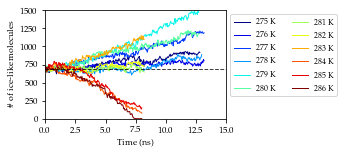

In [19]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3.25, 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
n=12
colors2 = plt.cm.jet(np.linspace(0,1,n))

fig, axs = plt.subplots(1,1)

timestep=0.0000005
step=10
step_dump=10000
temps=np.arange(275,287,1)
for i in range(temps.shape[0]):
    n_solid_molecules = np.load('n_solid_molecules600_' + str(temps[i]) + '_clust.npy')
    n_frames=n_solid_molecules.shape[0]
    plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules,label=str(temps[i]) + " K",linewidth=1,color=colors2[i])

plt.plot([0,15],[688,688],'--',alpha=0.75,linewidth=1,color='black')

plt.xlabel("Time (ns)")
plt.ylabel("\# of ice-like molecules")
plt.legend(ncol=2,fontsize=8,bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim([0,1500])
plt.xlim([0,15])
#plt.savefig("plot_cluster600.png",dpi=300,bbox_inches='tight')  # publication quality
plt.show()

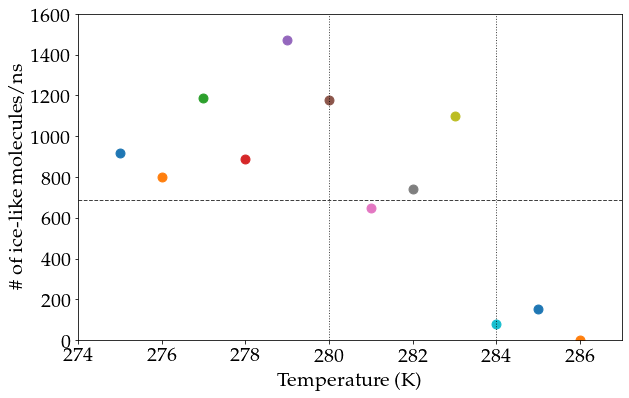

In [18]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3*3.25, 3*2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(1,1)

def func(x,a):
    b=680
    return a*x+b

temps=np.arange(275,287,1)
for i in range(temps.shape[0]):
    n_solid_molecules = np.load('n_solid_molecules600_' + str(temps[i]) + '_clust.npy')
    plt.scatter(temps[i],n_solid_molecules[-1],s=80)

plt.xlim([274,287])
plt.plot([274,287],[688,688],'--',alpha=0.75,linewidth=1,color='black')
plt.plot([280,280],[0,1600],':',alpha=0.75,linewidth=1,color='black')
plt.plot([284,284],[0,1600],':',alpha=0.75,linewidth=1,color='black')
plt.ylim([0,1600])
plt.xlabel("Temperature (K)")
plt.ylabel("\# of ice-like molecules/ns")

plt.show()

Based on the figure above, the highest temperature at which the crystal grows systematically is 280 K. The lowest temperature at which the crystal melts systematically is 284 K. Therefore the temperature at which the cluster is critical is 282 +- 2 K.

## Cluster size 5000

In [34]:
step=10
n_solid_molecules5000_292, n_solid_molecules5000_292_clust = computeLargestClusterSize('cluster5000molecules/292K/dump.water',step,292)
n_solid_molecules5000_293, n_solid_molecules5000_293_clust = computeLargestClusterSize('cluster5000molecules/293K/dump.water',step,293)
n_solid_molecules5000_294, n_solid_molecules5000_294_clust = computeLargestClusterSize('cluster5000molecules/294K/dump.water',step,294)
n_solid_molecules5000_295, n_solid_molecules5000_295_clust = computeLargestClusterSize('cluster5000molecules/295K/dump.water',step,295)
n_solid_molecules5000_296, n_solid_molecules5000_296_clust = computeLargestClusterSize('cluster5000molecules/296K/dump.water',step,296)

0.38559999999999994


In [35]:
np.save('n_solid_molecules5000_292_clust.npy', n_solid_molecules5000_292_clust)
np.save('n_solid_molecules5000_293_clust.npy', n_solid_molecules5000_293_clust)
np.save('n_solid_molecules5000_294_clust.npy', n_solid_molecules5000_294_clust)
np.save('n_solid_molecules5000_295_clust.npy', n_solid_molecules5000_295_clust)
np.save('n_solid_molecules5000_296_clust.npy', n_solid_molecules5000_296_clust)

In [24]:
# These simulations had slightly different settings
step=10
n_solid_molecules5000_290, n_solid_molecules5000_290_clust = computeLargestClusterSize('cluster5000molecules/290K/dump.water',step,290)
n_solid_molecules5000_291, n_solid_molecules5000_291_clust = computeLargestClusterSize('cluster5000molecules/291K/dump.water',step,291)
n_solid_molecules5000_295_2, n_solid_molecules5000_295_2_clust = computeLargestClusterSize('cluster5000molecules/295K_2/dump.water',step,295)

0.3897999999999999


<ipython-input-3-95e814767fe4>:21: RuntimeWarning: invalid value encountered in greater
  n_solid_molecules[counter]=ql.ql[ql.ql>threshold].shape[0]
<ipython-input-3-95e814767fe4>:22: RuntimeWarning: invalid value encountered in greater
  if (ts.positions[ql.ql>threshold,:].shape[0]>0):
<ipython-input-3-95e814767fe4>:23: RuntimeWarning: invalid value encountered in greater
  ts2 = MDAnalysis.coordinates.base.Timestep(ts.positions[ql.ql>threshold,:].shape[0])
<ipython-input-3-95e814767fe4>:24: RuntimeWarning: invalid value encountered in greater
  ts2.positions=ts.positions[ql.ql>threshold,:]


0.38896
0.38559999999999994
0.38476


In [28]:
np.save('n_solid_molecules5000_290_clust.npy', n_solid_molecules5000_290_clust)
np.save('n_solid_molecules5000_291_clust.npy', n_solid_molecules5000_291_clust)
np.save('n_solid_molecules5000_295_2_clust.npy', n_solid_molecules5000_295_2_clust)
np.save('n_solid_molecules5000_296_clust.npy', n_solid_molecules5000_296_clust)

In [36]:
# If already calculated, the results can be read using this cell
step=10
n_solid_molecules5000_292_clust = np.load('n_solid_molecules5000_292_clust.npy')
n_solid_molecules5000_293_clust = np.load('n_solid_molecules5000_293_clust.npy')
n_solid_molecules5000_294_clust = np.load('n_solid_molecules5000_294_clust.npy')
n_solid_molecules5000_295_clust = np.load('n_solid_molecules5000_295_clust.npy')
n_solid_molecules5000_296_clust = np.load('n_solid_molecules5000_296_clust.npy')

In [37]:
# If already calculated, the results can be read using this cell
step=10
n_solid_molecules5000_290_clust = np.load('n_solid_molecules5000_290_clust.npy')
n_solid_molecules5000_291_clust = np.load('n_solid_molecules5000_291_clust.npy')
n_solid_molecules5000_295_2_clust = np.load('n_solid_molecules5000_295_2_clust.npy')

In [38]:
samples=10
print(np.mean(n_solid_molecules5000_292_clust[:samples]))
print(np.mean(n_solid_molecules5000_293_clust[:samples]))
print(np.mean(n_solid_molecules5000_294_clust[:samples]))
print(np.mean(n_solid_molecules5000_295_clust[:samples]))
print(np.mean(n_solid_molecules5000_296_clust[:samples]))
np.mean([4691.5,4703.1,4646.7,4680.2,4657.5])

4691.5
4703.1
4646.7
4680.2
4657.5


4675.8

Thus, the initial mean cluster size is ~4675 molecules

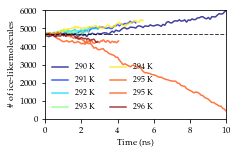

In [41]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3.25, 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(1,1)

colors2 = plt.cm.jet(np.linspace(0,1,7))
mylinewidth=1.5
timestep=0.0000005
step=10
step_dump=10000
step_dump_2=20000 # For the simulations with different settings

n_frames=n_solid_molecules5000_290_clust.shape[0]
plt.plot(step*step_dump_2*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_290_clust,label="290 K",linewidth=mylinewidth,color=colors2[0],alpha=0.75)
n_frames=n_solid_molecules5000_291_clust.shape[0]
plt.plot(step*step_dump_2*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_291_clust,label="291 K",linewidth=mylinewidth,color=colors2[1],alpha=0.75)
n_frames=n_solid_molecules5000_292_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_292_clust,label="292 K",linewidth=mylinewidth,color=colors2[2],alpha=0.75)
n_frames=n_solid_molecules5000_293_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_293_clust,label="293 K",linewidth=mylinewidth,color=colors2[3],alpha=0.75)
n_frames=n_solid_molecules5000_294_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_294_clust,label="294 K",linewidth=mylinewidth,color=colors2[4],alpha=0.75)
n_frames=n_solid_molecules5000_295_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_295_clust,label="295 K",linewidth=mylinewidth,color=colors2[5],alpha=0.75)
n_frames=n_solid_molecules5000_295_2_clust.shape[0]
plt.plot(step*step_dump_2*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_295_2_clust,label="295 K",linewidth=mylinewidth,color=colors2[5],alpha=0.75)
n_frames=n_solid_molecules5000_296_clust.shape[0]
plt.plot(step*step_dump*timestep*np.linspace(0,n_frames-1,n_frames),n_solid_molecules5000_296_clust,label="296 K",linewidth=mylinewidth,color=colors2[6],alpha=0.75)

plt.plot([0,10],[4676,4676],'--',alpha=0.75,linewidth=1,color='black')
plt.xlabel("Time (ns)")
plt.ylabel("\# of ice-like molecules")
plt.legend(frameon=False,ncol=2,fontsize=8)
plt.xlim([0,10])
plt.ylim([0,6000])

#plt.savefig("plot_cluster5000.png",dpi=300,bbox_inches='tight')  # publication quality

plt.show()